### Install and import packages

In [ ]:
# Install packages
!pip install bayes_logistic

In [1]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_list = ["Green", "Blue"]
color_map = mcolors.ListedColormap(["Green", "Blue"])

import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic

### Set parameters

In [9]:
# Set parameters
# num_data
num_data = 2
num_data_half = num_data // 2
num_feats = 2

# num_samples 
num_samples = 10000

# data_x marginal distribution parameters
data_x_marginal_params = [
    [[1.0, 5.0], [(1.0, 0.0), (0.0, 1.0)]],
    [[-5.0, 1.0], [(3.0, 0.0), (0.0, 3.0)]]]

# weights prior distribution parameters
weights_prior_params = [[0.0, 0.0], [[50.0, 0.0], [0.0, 50.0]]]

# init sigma used in numerical optimization for laplace approximation
laplace_init_sigma = 1.
laplace_num_iters = 1000


### Generate data_x

$$
\begin{align*}
  \mathrm{data}\_x &= [c_0\_x, c_1\_x]\\
  c_0\_x &\sim p(x|\mu_0, \sigma_0^2) \\
  c_1\_x &\sim p(x|\mu_1, \sigma_1^2)
\end{align*}
$$


In [19]:
# Generate data_x
# data_x_marginal_dists = [
#     stats.multivariate_normal(mu, sigma, seed=12345) \
#         for mu, sigma in data_x_marginal_params]

# c0_x = data_x_marginal_dists[0].rvs(size=(num_data_half))
# c1_x = data_x_marginal_dists[1].rvs(size=(num_data_half))
# data_x = np.vstack((c0_x, c1_x))

np.random.seed(0)
data_x = np.random.randn(num_data, num_feats)
data_x = np.array([[0, 1], [1, 0]])
print(data_x)
print(data_x.shape)

[[0 1]
 [1 0]]
(2, 2)


### Sample weights, generate sample y from sample weights and visualize data

#### Comments on the plots
1. Even though the data_x is set to be linearly separable, using random prior weights can lead to linearly nonseparable cases.

### Generate prior and posterior samples

Generate two set of prior samples A and B

$$
\begin{align*}
    & A = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta) \\
    & B = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta)
\end{align*}
$$

Generate a set of posterior from prior samples A

Notes: 
- $x$ is fixed and generated from the above procedure. Only $y_i$ is generated from $\theta_i$.

$$
\begin{align*}
    & C' = \{ \theta_i' \}_{i=1}^N, \\
    & \theta_i' \sim p(\theta|x, y_i), \\
    & y_i \sim p(y_i|x, \theta_i), \; \theta_i \in A
\end{align*}
$$

In [22]:
### Generate prior and posterior samples

# weights' prior distribution
weights_prior_dist_a = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=1)
weights_prior_dist_b = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=11)


samples_a_weights_prior = []
samples_b_weights_prior = []
samples_a_weights_posterior = []
samples_a_y = []
tmp1 = []
for i in range(1000):
    # sample two set of weights' priors 
    sample_a_weights_prior = weights_prior_dist_a.rvs(1)[None,:]
    sample_b_weights_prior = weights_prior_dist_b.rvs(1)[None,:]
    samples_a_weights_prior.append(sample_a_weights_prior)
    samples_b_weights_prior.append(sample_b_weights_prior)
    # print(sample_a_weights_prior.shape)
    # print(sample_b_weights_prior.shape)
    
    # generate sample y_i from theta_i in A
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    # print(sample_a_y)
    samples_a_y.append(sample_a_y)
    # stop
    
    # fit laplace approximation
    w_map, h_map = bayes_logistic.fit_bayes_logistic(
        y = sample_a_y.squeeze(-1),
        X = data_x, 
        # wprior = sample_a_weights_prior.squeeze(0), 
        wprior = np.array(weights_prior_params[0]), # note: we should initialize wprior same as prior params, though the results donot change much
        H = ((np.identity(num_feats)) * 0.02),
        weights = None,
        solver = "Newton-CG",
        bounds = None,
        maxiter = laplace_num_iters
    )
    cov_map = np.linalg.inv(h_map)
    
    # sample weights' posterior
    sample_a_weights_posterior = stats.multivariate_normal.rvs(w_map, cov_map)
    samples_a_weights_posterior.append(sample_a_weights_posterior)    
    tmp1.append([w_map, cov_map]) 
    

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

(1000, 2)


In [29]:
samples_a_score = np.sqrt(np.mean(samples_a_weights_prior[:,0]**2))
samples_b_score = np.sqrt(np.mean(samples_b_weights_prior[:,0]**2))
samples_a_pos_score = np.sqrt(np.mean(samples_a_weights_posterior[:,0]**2))

samples_a_var = np.std(samples_a_weights_prior[:,0], ddof=1)
samples_b_var = np.std(samples_b_weights_prior[:,0], ddof=1)
samples_a_pos_var = np.std(samples_a_weights_posterior[:,0], ddof=1)
print(samples_a_score)
print(samples_b_score)
print(samples_a_pos_score)
print()
print(samples_a_var)
print(samples_b_var)
print(samples_a_pos_var)

7.135645168880402
7.261327127363998
4.618470139571275

7.133743935111869
7.264932868057314
4.6186274696523


In [25]:
print(cov_map)

[[13.6643088  0.       ]
 [ 0.        13.6643088]]


In [24]:
samples_a_var = np.std(samples_a_weights_prior[:,1], ddof=1)
samples_b_var = np.std(samples_b_weights_prior[:,1], ddof=1)
samples_a_pos_var = np.std(samples_a_weights_posterior[:,1], ddof=1)
print(samples_a_var)
print(samples_b_var)
print(samples_a_pos_var)

7.0977064276759245
7.04356226901742
4.477762490923611


In [ ]:
# print(sample_a_weights_prior)
# print(cov_map)

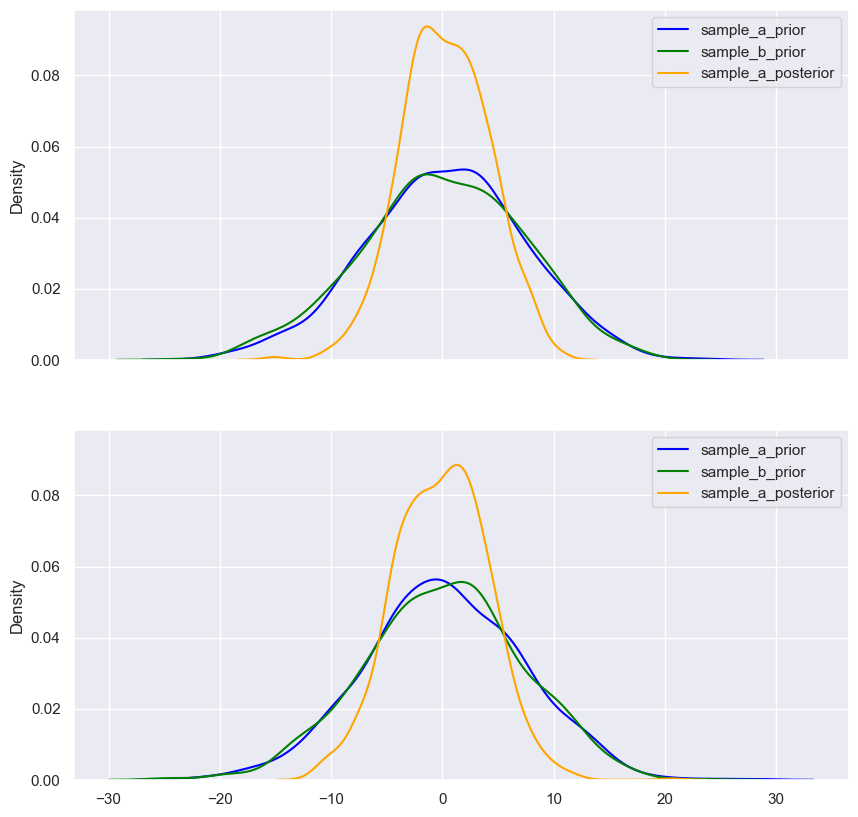

In [14]:
# Visualize the generated prior and posterior samples 
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,i], fill=False, color="blue", label="sample_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,i], fill=False, color="green", label="sample_b_prior", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,i], fill=False, color="orange", label="sample_a_posterior", ax=axes[i])
    axes[i].legend()
plt.show()

[array([ 3.17054363, -1.93626892]), array([[27.67940697, 11.38896206],
       [11.38896206, 41.83036615]])]
[array([ 3.17054363, -1.93626892]), array([[27.67940697, 11.38896206],
       [11.38896206, 41.83036615]])]
[array([ 3.17054363, -1.93626892]), array([[27.67940697, 11.38896206],
       [11.38896206, 41.83036615]])]
[array([ 3.17054363, -1.93626892]), array([[27.67940697, 11.38896206],
       [11.38896206, 41.83036615]])]
[array([ 3.17054363, -1.93626892]), array([[27.67940697, 11.38896206],
       [11.38896206, 41.83036615]])]
[array([ 3.17054363, -1.93626892]), array([[27.67940697, 11.38896206],
       [11.38896206, 41.83036615]])]
[array([ 3.17054363, -1.93626892]), array([[27.67940697, 11.38896206],
       [11.38896206, 41.83036615]])]
[array([ 3.17054363, -1.93626892]), array([[27.67940697, 11.38896206],
       [11.38896206, 41.83036615]])]
[array([ 3.17054363, -1.93626892]), array([[27.67940697, 11.38896206],
       [11.38896206, 41.83036615]])]
[array([ 3.17054363, -1.9362

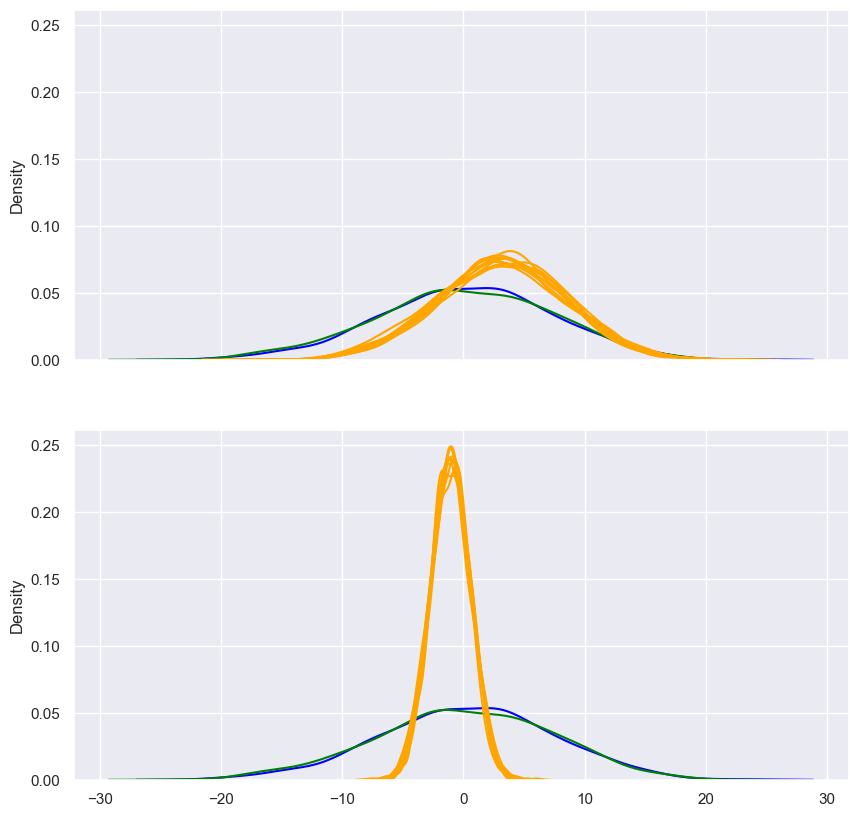

In [61]:
# Visualize the generated prior and posterior samples 
samples_a_weights_prior_tmp = samples_a_weights_prior[:10]
samples_b_weights_prior_tmp = samples_b_weights_prior[:10]
samples_a_weights_posterior = stats.multivariate_normal.rvs(tmp[0][0], tmp[0][1], size=1000)

nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,0], fill=False, color="blue", label="sample_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,0], fill=False, color="green", label="sample_b_prior", ax=axes[i])
    # sns.kdeplot(samples_a_weights_posterior[:,0], fill=False, color="orange", label="sample_a_posterior", ax=axes[i])
    for j in range(10):
        print(tmp1[i])
        sns.kdeplot(stats.multivariate_normal.rvs(tmp[i][0], tmp[i][1], size=1000)[:,0], fill=False, color="orange", label="sample_a_posterior", ax=axes[i])
    # axes[i].legend()
plt.show()

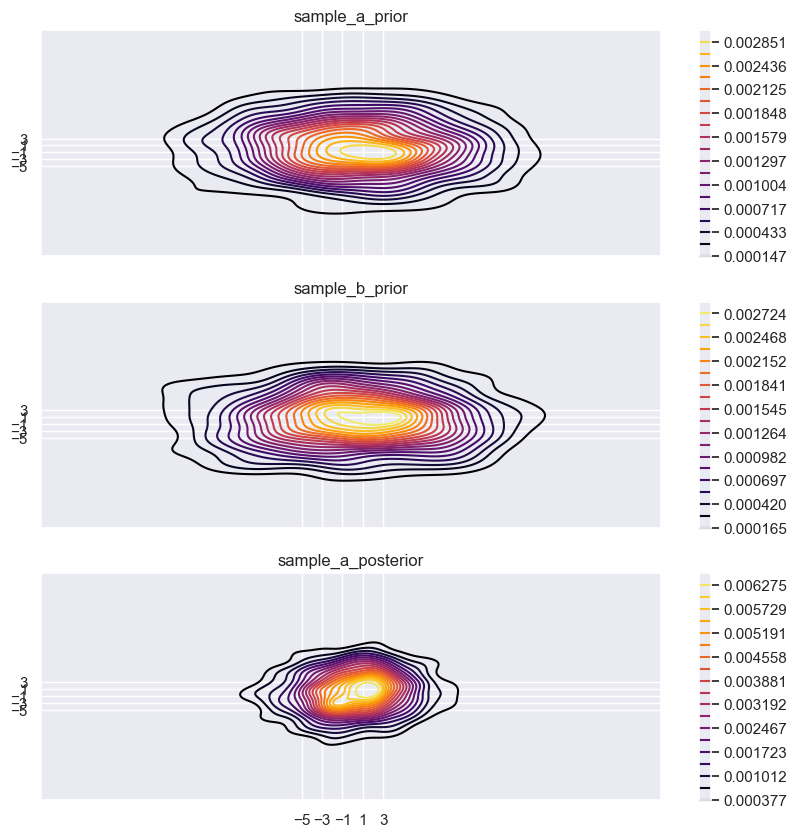

In [79]:
# Visualize the generated prior and posterior samples 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[2])
axes[0].set_xticks(np.arange(-5, 5, 2))
axes[0].set_yticks(np.arange(-5, 5, 2))
axes[0].set_title("sample_a_prior")
axes[1].set_title("sample_b_prior")
axes[2].set_title("sample_a_posterior")
plt.show()

#### Comments on the plots
1. In 2d, the posterior samples are quite different from the prior samples 